# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os

DATASET_PATH = '../datasets/traffic-signs-data'

training_file = os.path.join(DATASET_PATH, 'train.p')
validation_file = os.path.join(DATASET_PATH, 'valid.p')
testing_file = os.path.join(DATASET_PATH, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
from gtsrb_labels import gtsrb_label_map

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np
import pandas as pd

np.random.seed(0)

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.size

# TODO: Number of validation examples
n_validation = y_valid.size

# TODO: Number of testing examples.
n_test = y_test.size

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_valid).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [6]:
def plot_brief_stats_for(pickled_data, plot_title):
    total_val_items = pickled_data['labels'].size
    pickled_df = pd.DataFrame(pickled_data['labels'])
    # Copy the column for naming
    pickled_df['label_name'] = pickled_df[0].values
    # Using the name map to name columns
    named_df = pickled_df.replace({'label_name' : gtsrb_label_map})
    unique_labels = named_df.label_name.value_counts()
    # Validate we still have the same count of items in the original data
    # and the sum of value counts in the dataframe
    assert(total_val_items == unique_labels.sum())
    plt.figure(figsize=(8,15));
    unique_labels.plot.barh(title=plot_title)

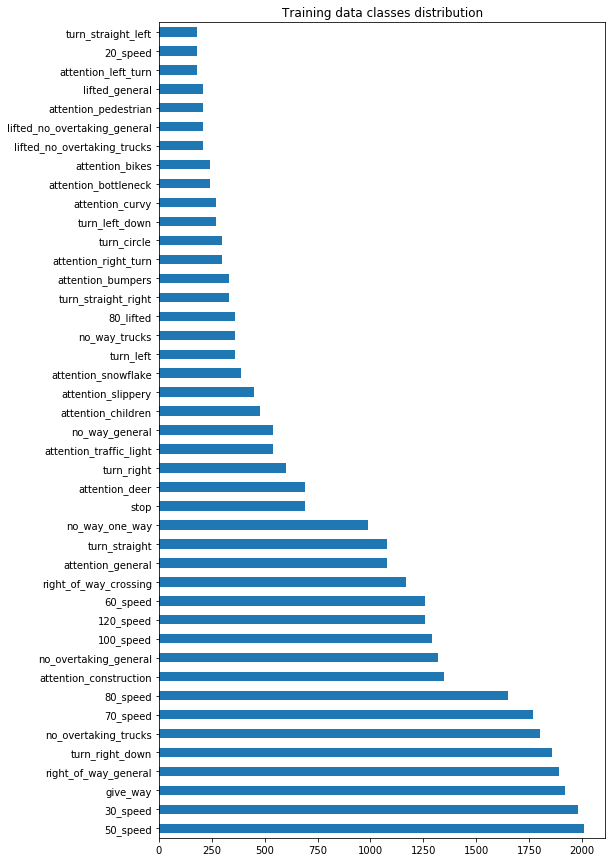

In [7]:
plot_brief_stats_for(train, "Training data classes distribution")

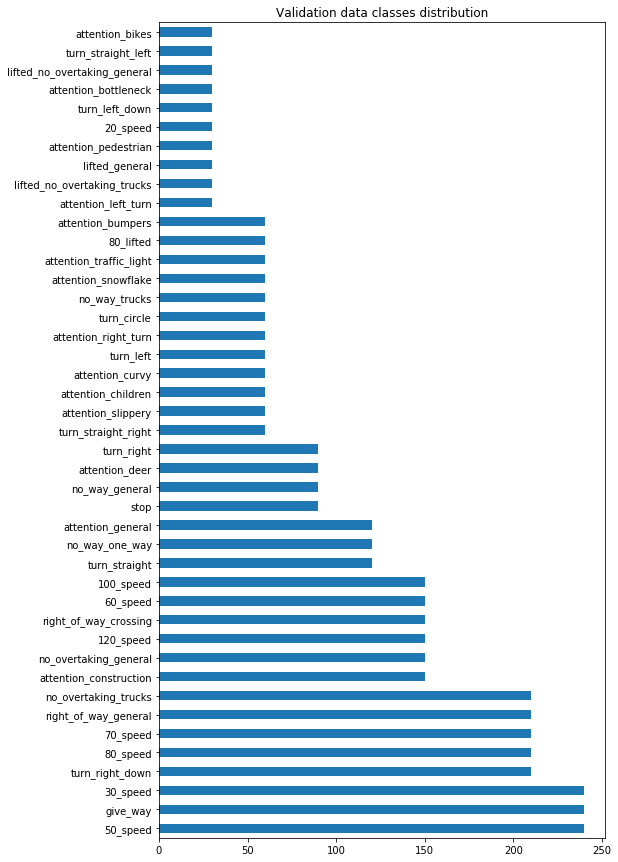

In [8]:
plot_brief_stats_for(valid, "Validation data classes distribution")

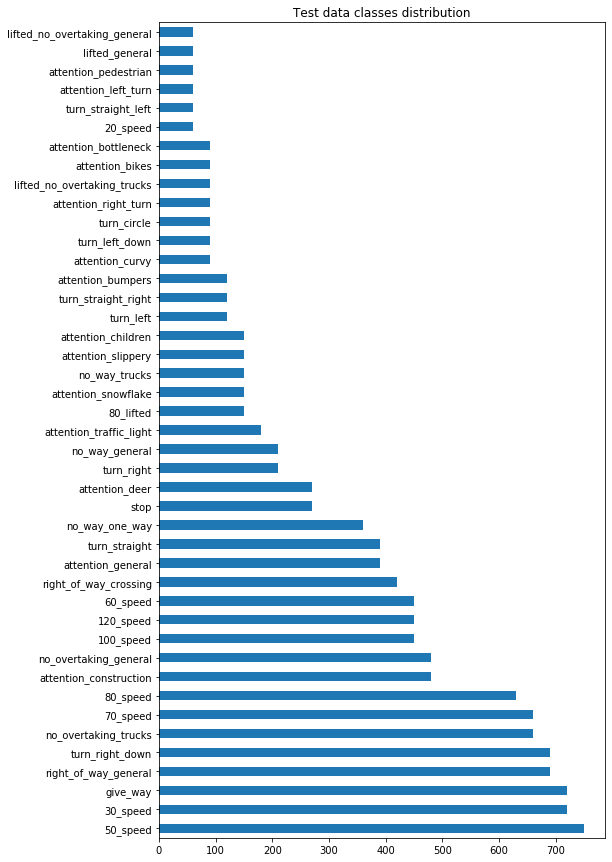

In [9]:
plot_brief_stats_for(test, "Test data classes distribution")

#### Dataset exploration conclusions

As it is described above, all the train, validation and test splits in GTSRB dataset have similar distributions. The most common classes are for signs '50_speed', '30_speed', 'give_way', and the rarest is 'attention_left_turn'. I suppose, that the model accuracy would be the best for most common signs and the poorest for the rarest ones.

Also I have noticed there is no 'no sign' or 'empty' class, so I suppose any model, trained on this dataset, would treat *any* image as a road sign and providing some non-zero probability for it. This should be taken into account when deploying the model.

Probably, a good investment would be to add some random images and/or noise to a special "empty" class, having the size of this class about 1/43 (TBD) of the total examples in the dataset - in this case the model might also detect that there is NO road sign in a given image.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
import cv2
from plot_helper import *

In [11]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
def normalize_pickle(img):
    fl = img.astype(np.float32)
    return (fl - 128.) / 128.
    
def to_gray(rgb_img):
    return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

In [12]:
# Augmentation: salt and pepper noise, horizontal flip, color bleaching
def flip_horizontally(img: np.array):
    '''
    Expects an image or a vector of images.
    Image rank must be 3; (32, 32, 1) for grayscale, (32,32,3) for RGB
    ''' 
    return np.fliplr(img)
    
def bleach(img: np.array, channel=2):
    '''
    Expects an image or a vector of images.
    Image rank must be 3; (32, 32, 1) for grayscale, (32,32,3) for RGB
    Channel is [0..2], 0 - red, 1 - green, ...
    "Bleaches" the given color channel.
    '''
    output = img.copy()
    output[:,:,channel] = img[:,:,channel] // 2 + img[:,:,channel] // 3
    return output
    
def salt_pepper(img: np.array, prob=0.2):
    '''
    Expects an image or a vector of images.
    Image rank must be 3; (32, 32, 1) for grayscale, (32,32,3) for RGB
    Prob is in range 0..1 - probability of noising this particular pixel.
    Based on 
    https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
    https://gist.github.com/lucaswiman/1e877a164a69f78694f845eab45c381a
    '''
    output = img.copy()
    min_ = img.min();
    max_ = img.max();
    if len(img.shape) == 2:
        black = min_
        white = max_            
    else:
        black = np.array([min_, min_, min_], dtype='uint8')
        white = np.array([max_, max_, max_], dtype='uint8')
    probs = np.random.random(img.shape[:2])
    output[probs < (prob / 2)] = black
    output[probs > (1 - (prob / 4))] = white
    return output

Stats : min 9 mean 17.389322916666668 max 54


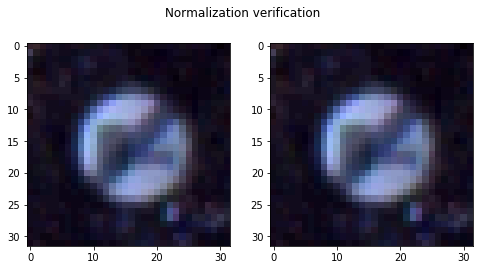

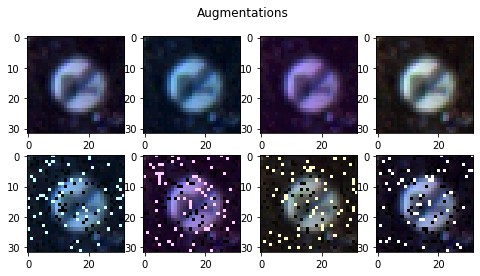

In [13]:
# Plotting preprocessing step examples.
# The "normalized" image, converted back (to_image(...)) must
# looks very close to the original feature array, converted to_image.
img_piece = valid['features'][1300].copy()

print("Stats : min {} mean {} max {}".format(img_piece.min(), img_piece.mean(), img_piece.max()))

norm = normalize_pickle(img_piece)

two_f = plt.figure(figsize=(8,4))
two_f.suptitle("Normalization verification")
two_f.add_subplot(1, 2, 1)
plt.imshow(to_image(img_piece))
two_f.add_subplot(1, 2, 2)
plt.imshow(to_image(norm))

# Display various augmentations and their combinations
f = plt.figure(figsize=(8,4))
f.suptitle("Augmentations")
f.add_subplot(2, 4, 1)
plt.imshow(to_image(img_piece))
f.add_subplot(2, 4, 2)
plt.imshow(to_image(bleach(img_piece, 0)))
f.add_subplot(2, 4, 3)
plt.imshow(to_image(bleach(img_piece, 1)))
f.add_subplot(2, 4, 4)
plt.imshow(to_image(bleach(img_piece, 2)))
f.add_subplot(2, 4, 5)
plt.imshow(to_image(bleach(salt_pepper(img_piece), 0)))
f.add_subplot(2, 4, 6)
plt.imshow(to_image(bleach(salt_pepper(img_piece), 1)))
f.add_subplot(2, 4, 7)
plt.imshow(to_image(bleach(salt_pepper(img_piece), 2)))
f.add_subplot(2, 4, 8)
plt.imshow(to_image(salt_pepper(img_piece)))
plt.show(block=True)


In [14]:
# Normalize and augment train, validation and test datasets.
# For each train image we create 7 augmented ones:
# 1. bleached green
# 2. bleached red
# 3. bleached blue
# 4. salt_pepper + bleached green
# 5. salt_pepper + bleached red
# 6. salt_pepper + bleached blue
# 7. salt_pepper

salted = X_train.copy()
bleach_0 = X_train.copy()
bleach_1 = X_train.copy()
bleach_2 = X_train.copy()
salted_bleach_0 = X_train.copy()
salted_bleach_1 = X_train.copy()
salted_bleach_2 = X_train.copy()
for i in range(0, X_train.shape[0]):
    salted[i] = salt_pepper(X_train[i])
    bleach_0[i] = bleach(X_train[i], 0)
    bleach_2[i] = bleach(X_train[i], 1)
    bleach_1[i] = bleach(X_train[i], 2)
    salted_bleach_0[i] = bleach(salt_pepper(X_train[i]), 0)
    salted_bleach_1[i] = bleach(salt_pepper(X_train[i]), 1)
    salted_bleach_2[i] = bleach(salt_pepper(X_train[i]), 2)


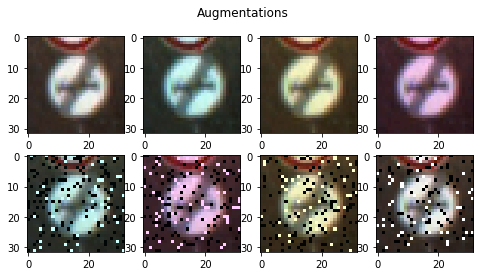

In [15]:
# Visualize some augmented training images
IMG_TO_SHOW = 9
f = plt.figure(figsize=(8,4))
f.suptitle("Augmentations")
f.add_subplot(2, 4, 1)
plt.imshow(to_image(X_train[IMG_TO_SHOW]))
f.add_subplot(2, 4, 2)
plt.imshow(to_image(bleach_0[IMG_TO_SHOW]))
f.add_subplot(2, 4, 3)
plt.imshow(to_image(bleach_1[IMG_TO_SHOW]))
f.add_subplot(2, 4, 4)
plt.imshow(to_image(bleach_2[IMG_TO_SHOW]))
f.add_subplot(2, 4, 5)
plt.imshow(to_image(salted_bleach_0[IMG_TO_SHOW]))
f.add_subplot(2, 4, 6)
plt.imshow(to_image(salted_bleach_1[IMG_TO_SHOW]))
f.add_subplot(2, 4, 7)
plt.imshow(to_image(salted_bleach_2[IMG_TO_SHOW]))
f.add_subplot(2, 4, 8)
plt.imshow(to_image(salted[IMG_TO_SHOW]))
plt.show(block=True)

In [16]:
# Stack the augmented data back to training dataset
# with the same labels
X_train_aug = np.concatenate([
    X_train,
    salted,
    bleach_0,
    bleach_1,
    bleach_2,
    salted_bleach_0,
    salted_bleach_1,
    salted_bleach_2,
], axis=0)
assert(X_train_aug.shape[0] == X_train.shape[0] * 8)

y_train_aug = np.concatenate([y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train], axis=0)
assert(y_train_aug.shape[0] == y_train.shape[0] * 8)

In [17]:
xlen = X_train.shape[0]
ylen = y_train.shape[0]
print(xlen,ylen)
limit = 209
print(y_train[limit])
print(y_train_aug[limit], y_train_aug[xlen + limit])


34799 34799
41
41 41


### Model Architecture

In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

/home/rattus/venvratt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rattus/venvratt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rattus/venvratt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rattus/venvratt/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [19]:
GTSRB_CLASSES = 43

In [35]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout_rate):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Convolution filter
    filter_size_width = 5
    filter_size_height = 5
    color_channels = 3
    conv2d_1_output = 6
    # Input/Image
    input = tf.placeholder(
        tf.float32,
        shape=[None, 32, 32, color_channels])
    print('input : ', input.shape)
    print('x : ', x.shape)
    
    # Weight and bias
    conv2d_1_W = tf.Variable(tf.truncated_normal(shape=(filter_size_height, filter_size_width, color_channels, conv2d_1_output)
                                                , mean=mu, stddev=sigma))
    conv2d_1_b = tf.Variable(tf.zeros(conv2d_1_output))

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv2d_1 = tf.nn.conv2d(x, conv2d_1_W, strides=[1, 1, 1, 1], padding='VALID')
    conv2d_1 = tf.nn.bias_add(conv2d_1, conv2d_1_b)
    conv2d_1 = tf.nn.relu(conv2d_1)
    print('conv2d_1 : ', conv2d_1.shape)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    max_pool_1 = tf.nn.max_pool(conv2d_1, ksize=[1,3,3,1], strides=[1, 1, 1, 1], padding='VALID')
    print('max_pool_1 : ', max_pool_1.shape)
    
    dropout_1 = tf.nn.dropout(max_pool_1, rate=dropout_rate)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2d_2_output = 16
    conv2d_2_W = tf.Variable(tf.truncated_normal(shape=(filter_size_height, 
                                                        filter_size_width, conv2d_1_output, conv2d_2_output)
                                                 , mean=mu, stddev=sigma))
    conv2d_2_b = tf.Variable(tf.zeros(conv2d_2_output))
    
    conv2d_2 = tf.nn.conv2d(dropout_1, conv2d_2_W, strides=[1, 1, 1, 1], padding='VALID')
    conv2d_2 = tf.nn.bias_add(conv2d_2, conv2d_2_b)
    conv2d_2 = tf.nn.relu(conv2d_2)
    print('conv_layer_2 : ', conv2d_2.shape)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    max_pool_2 = tf.nn.max_pool(conv2d_2, ksize=[1,3,3,1], strides=[1, 2, 2, 1], padding='VALID')
    print('max_pool_2 : ', max_pool_2.shape)
    
    dropout_2 = tf.nn.dropout(max_pool_2, rate=dropout_rate)

        # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2d_3_output = 32
    conv2d_3_W = tf.Variable(tf.truncated_normal(shape=(filter_size_height, filter_size_width,
                                                        conv2d_2_output, conv2d_3_output)
                                                , mean=mu, stddev=sigma))
    conv2d_3_b = tf.Variable(tf.zeros(conv2d_3_output))
    
    conv2d_3 = tf.nn.conv2d(dropout_2, conv2d_3_W, strides=[1, 1, 1, 1], padding='VALID')
    conv2d_3 = tf.nn.bias_add(conv2d_3, conv2d_3_b)
    conv2d_3 = tf.nn.relu(conv2d_3)
    print('conv_layer_3 : ', conv2d_3.shape)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    max_pool_3 = tf.nn.max_pool(conv2d_3, ksize=[1,3,3,1], strides=[1, 2, 2, 1], padding='VALID')
    print('max_pool_2 : ', max_pool_3.shape)
    
    dropout_3 = tf.nn.dropout(max_pool_3, rate=dropout_rate)

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flatt = flatten(dropout_3)
    print('flatten : ', flatt.shape)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120. # TODO: Activation.
    dense_1_out = GTSRB_CLASSES * 2
    dense_1_W = tf.Variable(tf.truncated_normal(shape=(int(flatt.shape[-1]), dense_1_out)
                                                , mean=mu, stddev=sigma ))
    dense_1_b = tf.Variable(tf.truncated_normal([dense_1_out]))
    dense_1 = tf.nn.relu(tf.add(tf.matmul(flatt, dense_1_W), dense_1_b))
    print('dense_1 : ', dense_1.shape)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84. # TODO: Activation.
    '''dense_2_out = GTSRB_CLASSES * 2
    dense_2_W = tf.Variable(tf.truncated_normal([dense_1_out, dense_2_out]))
    dense_2_b = tf.Variable(tf.truncated_normal([dense_2_out]))
    dense_2 = tf.nn.relu(tf.add(tf.matmul(dense_1, dense_2_W), dense_2_b))
    print('dense_2 : ', dense_2.shape)'''
    
    # TODO: Layer 5: Fully Connected. Input = 86. Output = 10.
    dense_3_out = GTSRB_CLASSES * 1
    dense_3_W = tf.Variable(tf.truncated_normal(shape=(dense_1_out, dense_3_out)
                                                , mean=mu, stddev=sigma ))
    dense_3_b = tf.Variable(tf.truncated_normal([dense_3_out]))
    dense_3 = tf.add(tf.matmul(dense_1, dense_3_W), dense_3_b)
    print('dense_3 : ', dense_3.shape)
    
    logits = dense_3#tf.nn.softmax(dense_3)
    return logits

In [36]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
d_rate = tf.placeholder(tf.float32, ())
one_hot_y = tf.one_hot(y, GTSRB_CLASSES)

## Training Pipeline
Create a training pipeline that uses the model to classify GTSRB data.

You do not need to modify this section.

In [37]:
rate = 0.001

logits = LeNet(x, d_rate)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

input :  (?, 32, 32, 3)
x :  (?, 32, 32, 3)
conv2d_1 :  (?, 28, 28, 6)
max_pool_1 :  (?, 26, 26, 6)
conv_layer_2 :  (?, 22, 22, 16)
max_pool_2 :  (?, 10, 10, 16)
conv_layer_3 :  (?, 6, 6, 32)
max_pool_2 :  (?, 2, 2, 32)
flatten :  (?, 128)
dense_1 :  (?, 86)
dense_3 :  (?, 43)


In [38]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [24]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train_aug, y_train_aug)

# Fraction can be used for preliminary short runs over a huge augmented dataset
# for coarse tuning of hyperparams
TRAIN_FRACTION = X_train.shape[0] // 10

X_train = normalize_pickle(X_train)[:TRAIN_FRACTION]
y_train = y_train[:TRAIN_FRACTION]

X_valid = normalize_pickle(X_valid)
X_test = normalize_pickle(X_test)


In [25]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, d_rate=0.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
# Before training, check that we are on GPU
print(tf.__version__)
print("TF built with GPU support : ", tf.test.is_built_with_cuda())
print("GPU available : ", tf.test.is_gpu_available())

1.14.0
TF built with GPU support :  False
GPU available :  False


In [27]:
BATCH_SIZE = 2048
EPOCHS = 50
accuracies = []

In [28]:
with tf.Session() as sess:
    accuracies = []
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training on {} examples ...".format(X_train.shape[0]))
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, d_rate: 0.25})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        accuracies.append(validation_accuracy)
        print()
        
    saver.save(sess, './traffic_sign_lenet')
    print("Model saved")

Training on 278392 examples ...

EPOCH 1 ...
Validation Accuracy = 0.564

EPOCH 2 ...
Validation Accuracy = 0.788

EPOCH 3 ...
Validation Accuracy = 0.844

EPOCH 4 ...
Validation Accuracy = 0.870

EPOCH 5 ...
Validation Accuracy = 0.874

EPOCH 6 ...
Validation Accuracy = 0.888

EPOCH 7 ...
Validation Accuracy = 0.896

EPOCH 8 ...
Validation Accuracy = 0.900

EPOCH 9 ...
Validation Accuracy = 0.906

EPOCH 10 ...
Validation Accuracy = 0.909

EPOCH 11 ...
Validation Accuracy = 0.910

EPOCH 12 ...
Validation Accuracy = 0.909

EPOCH 13 ...
Validation Accuracy = 0.908

EPOCH 14 ...
Validation Accuracy = 0.918

EPOCH 15 ...
Validation Accuracy = 0.922

EPOCH 16 ...
Validation Accuracy = 0.918

EPOCH 17 ...
Validation Accuracy = 0.925

EPOCH 18 ...
Validation Accuracy = 0.918



KeyboardInterrupt: 

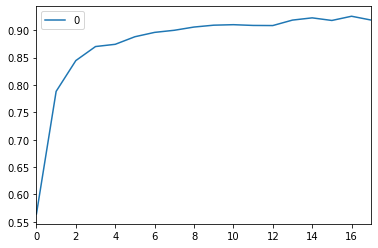

In [29]:
acc_plot = pd.DataFrame(accuracies)
acc_plot.plot.line()

##### LeNet on 10 epochs is ~ 0.96 validation, can I beat this?

batch 1024, 20 epochs, preprocessed -- the dynamic is ok, result soso (0.068)

batch 128,  20 epochs, preprocessed -- the dynamic is the same, result the same (0.065)

batch 128,  20 epochs, grayscale -- dynamics is shit already.

batch 200,  20 epochs, grayscale -- 0.055

8-32-d-d 0.055

okay, batch 32 -- still the same.
batch 512 -- shit.

OKay, 3 Conv layers added -- the dynamics is nice up to 0.3, then falls down. Why?

Oh, the (mean=mu, stddev=sigma) thing in the weight initialization! it really did the trick!

Preprocessed color, B128, 20 epochs.
0.944 - not bad!

##### Dropout and augmentation

x8 augmentation, batch 512. Very long epoch (GPU needed)

x8 augm, 5k examples, batch 1024, dropout, 100 epochs - max 0.78

x8 augm, 20k examples, batch 1024, dropout, 100 epochs - 0.78 on 20 ep. 0.85 on 40 ep. 0.88 on 60, 0.904 final

x8 augm, 280k examples, batch 2048, dropout, 50 epochs -
valacc 0.57 on 1st epoch! 0.788 on second, 0.888 on 6th. 0.9 on 13., 0.92 on 15

##### Damn, I still use dropout on validation and testing!

I need to set the dropout as a placeholder and remove it while validation.


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")